# Ideas and useful sources
## 1. Similar competitions
### - Smoker status:
### - https://www.kaggle.com/code/cv13j0/efficient-prediction-of-smoker-status
### - https://www.kaggle.com/code/arunklenin/ps3e24-eda-feature-engineering-ensemble
### -  https://www.kaggle.com/code/ravi20076/playgrounds3e24-eda-baseline
### - https://www.kaggle.com/code/oscarm524/ps-s3-ep24-eda-modeling-submission
### -  https://www.kaggle.com/code/ashishkumarak/binary-classification-smoker-or-not-eda-xgboost

## 2. Ideas and Tasks
### - Logging
### - Turning into classes and functions (config classes)
### - Optuna + model ensemble (use this notebook: https://www.kaggle.com/code/rzatemizel/ensemble-pipeline)
### - Explore more feature engineering
### - SHAP

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utils.eda import  summary, plot_correlation_heatmap

In [2]:
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [4]:
summary_df = summary(test_df)
summary_df

data shape: (110023, 13)
Number of duplicates found and removed: 0


,data type,#missing,%missing,#unique,min,max,average,standard_deviation,first value,second value,third value
id,int64,0,0.00,110023,"165,034.00","275,056.00","220,045.00","31,761.05",165034,165035,165036
CustomerId,int64,0,0.00,19698,"15,565,701.00","15,815,690.00","15,692,096.61","71,684.99",15773898,15782418,15807120
Surname,object,0,0.00,2708,NaN,NaN,NaN,NaN,Lucchese,Nott,K?
CreditScore,int64,0,0.00,454,350.00,850.00,656.53,80.32,586,683,656
Geography,object,0,0.00,3,NaN,NaN,NaN,NaN,France,France,France
Gender,object,0,0.00,2,NaN,NaN,NaN,NaN,Female,Female,Female
Age,float64,0,0.00,74,18.00,92.00,38.12,8.86,23.00,46.00,34.00
Tenure,int64,0,0.00,11,0.00,10.00,5.00,2.81,2,2,7
Balance,float64,0,0.00,22513,0.00,"250,898.09","55,333.61","62,788.52",0.00,0.00,0.00
NumOfProducts,int64,0,0.00,4,1.00,4.00,1.55,0.54,2,1,2


In [5]:
summary_df = summary(train_df)
summary_df

data shape: (165034, 14)
Number of duplicates found and removed: 0


,data type,#missing,%missing,#unique,min,max,average,standard_deviation,first value,second value,third value
id,int64,0,0.00,165034,0.00,"165,033.00","82,516.50","47,641.36",0,1,2
CustomerId,int64,0,0.00,23221,"15,565,701.00","15,815,690.00","15,692,005.02","71,397.82",15674932,15749177,15694510
Surname,object,0,0.00,2797,NaN,NaN,NaN,NaN,Okwudilichukwu,Okwudiliolisa,Hsueh
CreditScore,int64,0,0.00,457,350.00,850.00,656.45,80.10,668,627,678
Geography,object,0,0.00,3,NaN,NaN,NaN,NaN,France,France,France
Gender,object,0,0.00,2,NaN,NaN,NaN,NaN,Male,Male,Male
Age,float64,0,0.00,71,18.00,92.00,38.13,8.87,33.00,33.00,40.00
Tenure,int64,0,0.00,11,0.00,10.00,5.02,2.81,3,1,10
Balance,float64,0,0.00,30075,0.00,"250,898.09","55,478.09","62,817.66",0.00,0.00,0.00
NumOfProducts,int64,0,0.00,4,1.00,4.00,1.55,0.55,2,2,2


## 2. Numerical/Categorical Data Split

In [6]:
cat_cols = [column for column in train_df.columns if train_df[column].dtype == 'object']
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

num_cols.remove('id')
num_cols.remove('Exited')
num_cols.remove('CustomerId')
cat_cols.remove('Surname')

num_cols.remove('IsActiveMember')
cat_cols.append('IsActiveMember')

num_cols.remove('Tenure')
cat_cols.append('Tenure')

num_cols.remove('NumOfProducts')
cat_cols.append('NumOfProducts')

num_cols.remove('HasCrCard')
cat_cols.append('HasCrCard')

target_col = 'Exited'

train_df['HasCrCard'].astype('category')
train_df['IsActiveMember'].astype('category');

In [7]:
print(f'Category Columns: {cat_cols}')
print(f'Numerical Columns: {num_cols}')
print(f'Target Column: {target_col}')

Category Columns: ['Geography', 'Gender', 'IsActiveMember', 'Tenure', 'NumOfProducts', 'HasCrCard']
Numerical Columns: ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
Target Column: Exited


## 2. Target Distribution
Source: https://www.kaggle.com/code/arunklenin/ps4e1-advanced-feature-engineering-ensemble

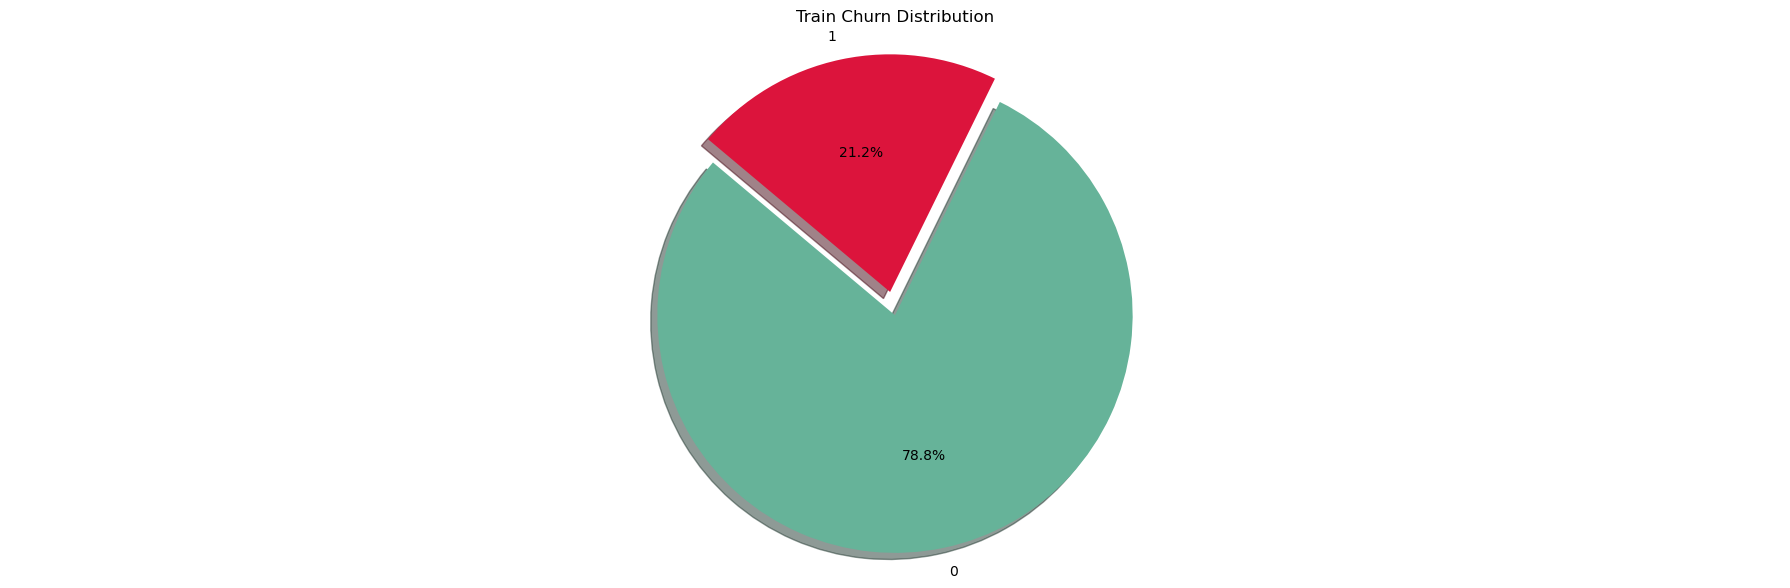

In [8]:
def plot_pie_chart(data, title, ax):
    data_counts = data[target_col].value_counts()
    labels = data_counts.index
    sizes = data_counts.values
    colors = [ (0.4, 0.7, 0.6), 'crimson']  
    explode = (0.1, 0)  

    ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal') 
    ax.set_title(title)

fig, axes = plt.subplots(1, 1, figsize=(18, 6))  # Create three subplots in a row

plot_pie_chart(train_df, "Train Churn Distribution", axes)

plt.tight_layout()
plt.show()

## 3. EDA Numerical Data Analysis 
Source: https://www.kaggle.com/code/arunklenin/ps4e1-advanced-feature-engineering-ensemble

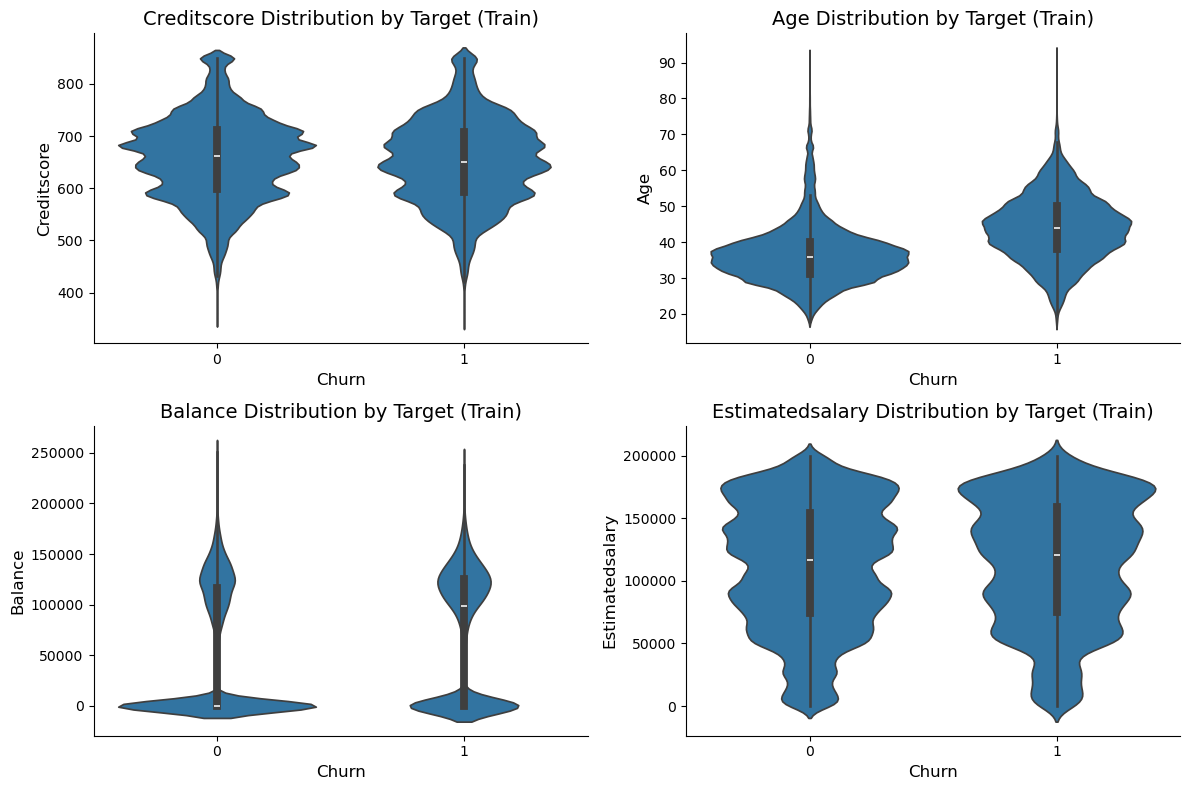

In [9]:
n_rows = len(num_cols)
n_cols = 2
fig, axs = plt.subplots(n_rows // n_cols, n_cols, figsize=(12, 4 * (n_rows // n_cols)))
sns.set_palette("Set3")

for i, col in enumerate(num_cols):
    row_idx = i // n_cols
    col_idx = i % n_cols

    sns.violinplot(x=target_col, y=col, data=train_df, ax=axs[row_idx, col_idx])
    axs[row_idx, col_idx].set_title(f'{col.title()} Distribution by Target (Train)', fontsize=14)
    axs[row_idx, col_idx].set_xlabel('Churn', fontsize=12)
    axs[row_idx, col_idx].set_ylabel(col.title(), fontsize=12)
    sns.despine()

fig.tight_layout()

plt.show()

## 4. EDA Categorical Data Analysis
Source: https://www.kaggle.com/code/arunklenin/ps4e1-advanced-feature-engineering-ensemble

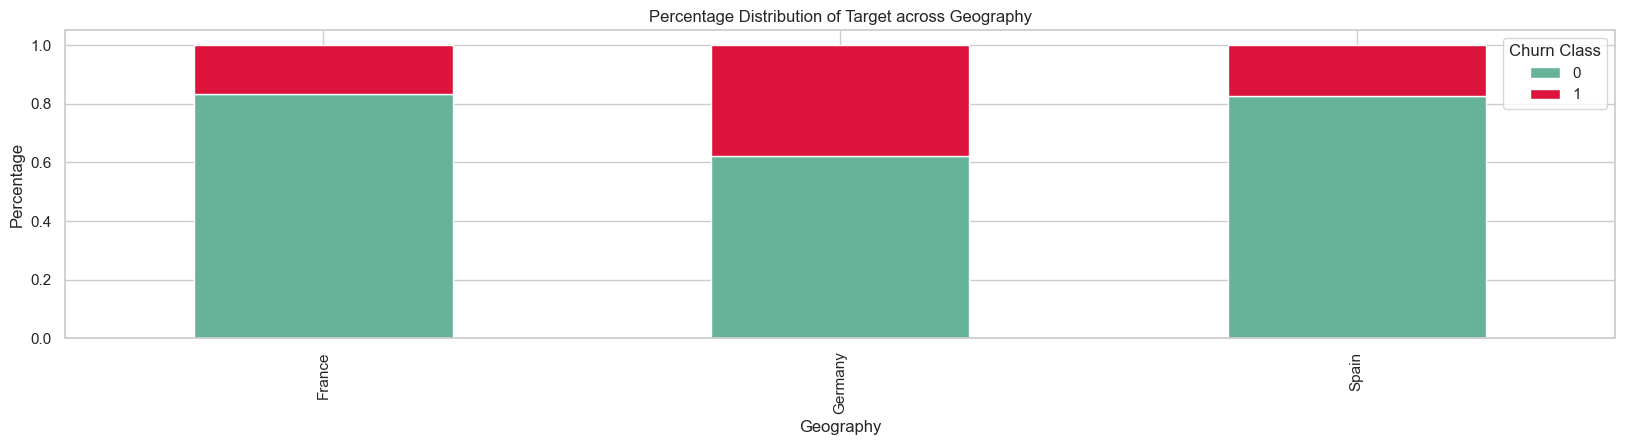

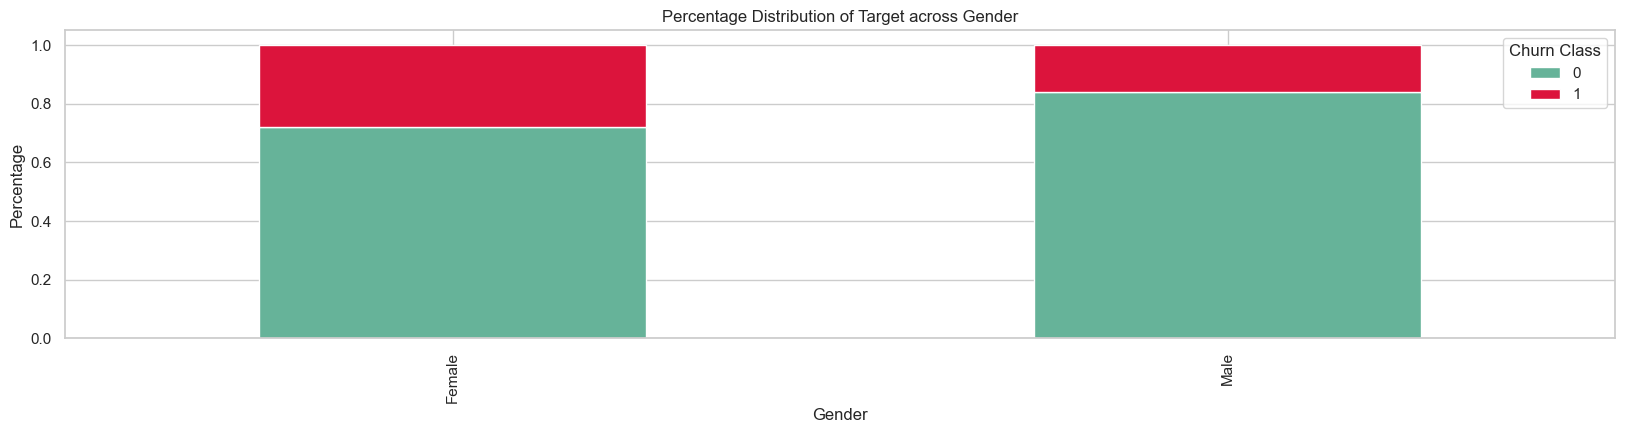

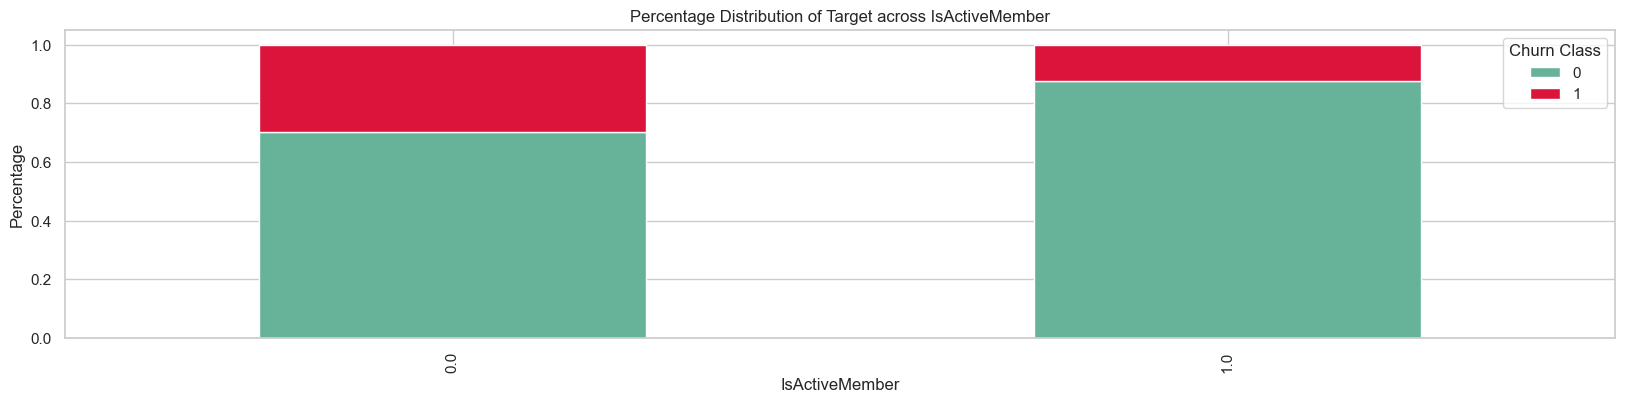

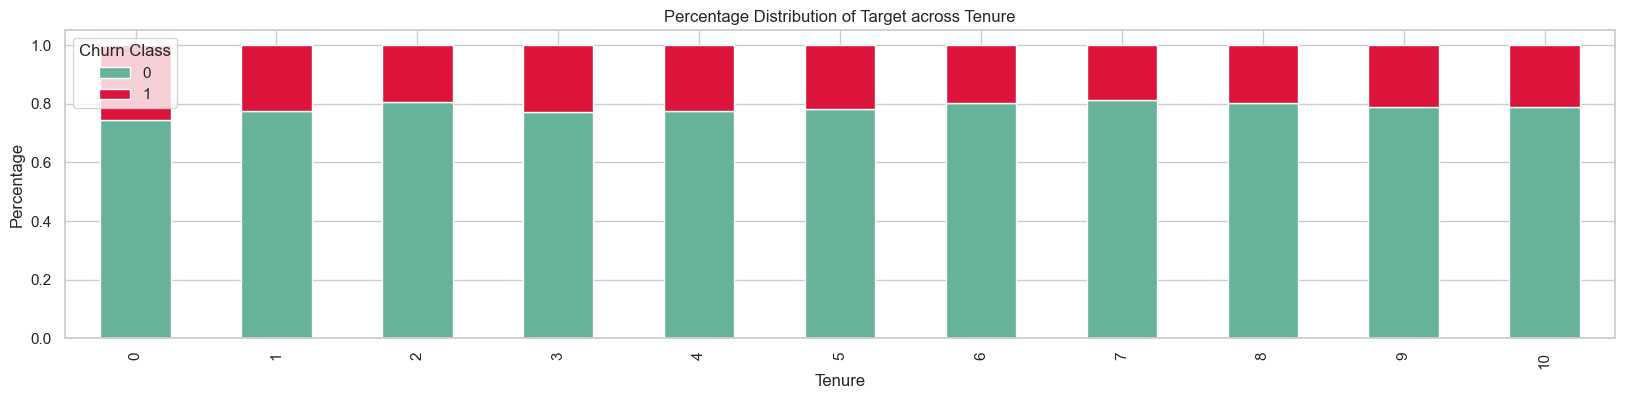

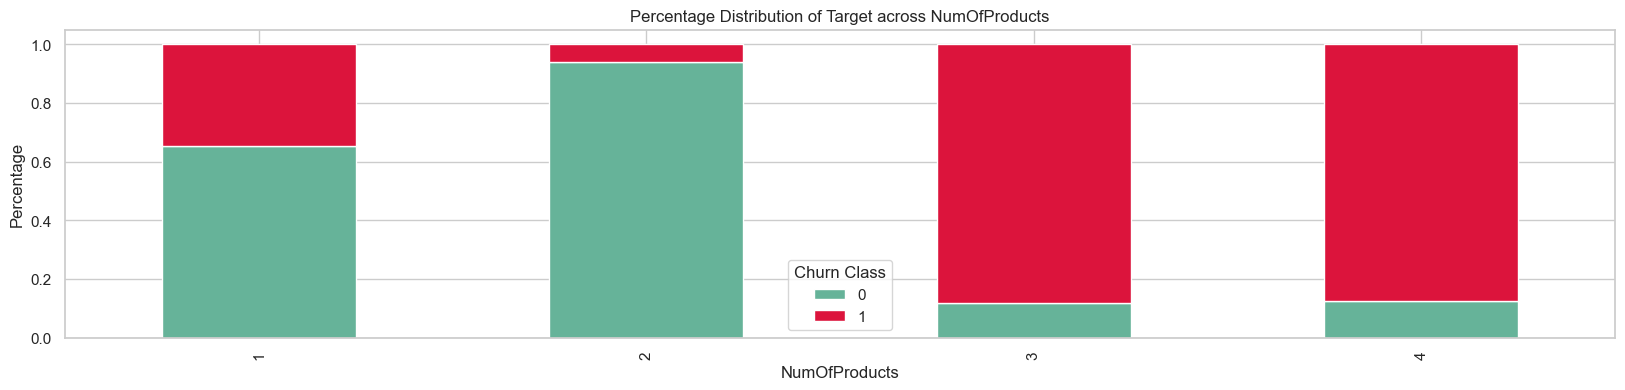

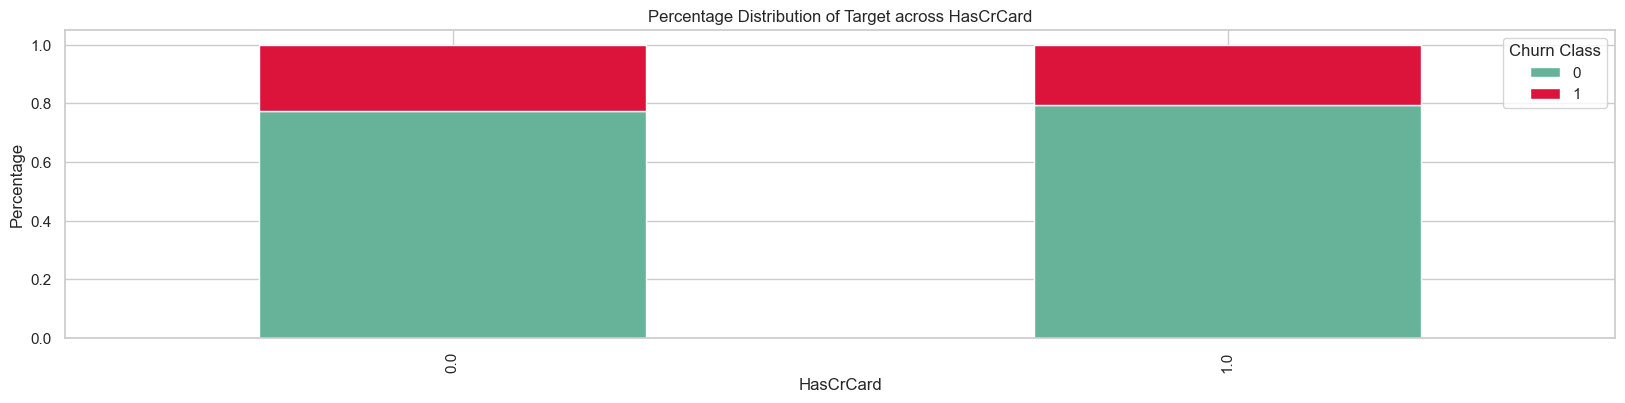

In [10]:
custom_palette =(0.4, 0.7, 0.6), 'crimson'
for col in cat_cols:
    contingency_table = pd.crosstab(train_df[col], train_df[target_col], normalize='index')
    sns.set(style="whitegrid")
    contingency_table.plot(kind="bar", stacked=True, color=custom_palette,figsize=(20, 4))
    plt.title(f"Percentage Distribution of Target across {col}")
    plt.xlabel(col)
    plt.ylabel("Percentage")
    plt.legend(title="Churn Class")
    plt.show()

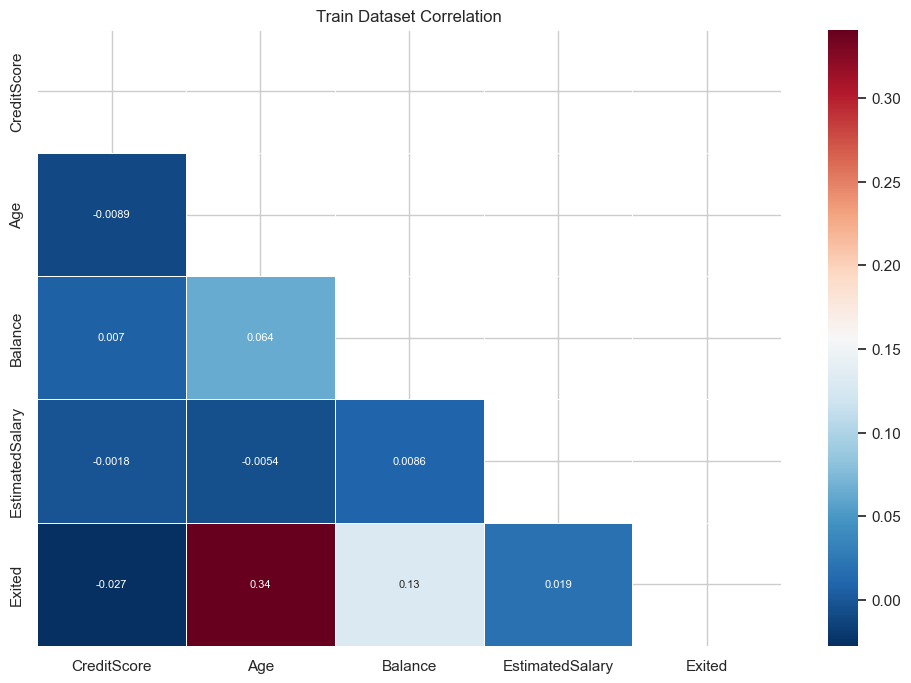

In [11]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:

    corr = df.corr()
    fig, axes = plt.subplots(figsize=(12, 8))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='RdBu_r', annot=True,annot_kws={"size": 8})
    plt.title(title_name)
    plt.show()


plot_correlation_heatmap(train_df[num_cols+[target_col]], 'Train Dataset Correlation')

## 5. Feature Engineering
### 5.1 Arithmetical Operations betweeen columns

In [12]:
num_cols

['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [13]:
# Perform arithmetic operations and add new columns
new_num_cols = []
for i, col1 in enumerate(num_cols):
    for j, col2 in enumerate(num_cols):
        if i != j:  # Avoid combining a column with itself
            new_column_name = f'{col1}+{col2}'  # Custom new column name
            train_df[new_column_name] = train_df[col1] + train_df[col2]
            new_num_cols.append(new_column_name)

            new_column_name = f'{col1}/{col2}'  # Custom new column name
            train_df[new_column_name] = train_df[col1] / train_df[col2]
            new_num_cols.append(new_column_name)
            
            new_column_name = f'{col1}*{col2}'  # Custom new column name
            train_df[new_column_name] = train_df[col1] * train_df[col2]
            new_num_cols.append(new_column_name)
            
            new_column_name = f'{col1}-{col2}'  # Custom new column name
            train_df[new_column_name] = train_df[col1] - train_df[col2]
            new_num_cols.append(new_column_name)

In [15]:
num_cols = num_cols + new_num_cols

In [18]:
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,EstimatedSalary*CreditScore,EstimatedSalary-CreditScore,EstimatedSalary+Age,EstimatedSalary/Age,EstimatedSalary*Age,EstimatedSalary-Age,EstimatedSalary+Balance,EstimatedSalary/Balance,EstimatedSalary*Balance,EstimatedSalary-Balance
0,0,15674932,Okwudilichukwu,668,France,Male,33.00,3,0.00,2,...,"121,208,579.96","180,781.97","181,482.97","5,498.48","5,987,849.01","181,416.97","181,449.97",inf,0.00,"181,449.97"
1,1,15749177,Okwudiliolisa,627,France,Male,33.00,1,0.00,2,...,"31,038,694.50","48,876.50","49,536.50","1,500.11","1,633,615.50","49,470.50","49,503.50",inf,0.00,"49,503.50"
2,2,15694510,Hsueh,678,France,Male,40.00,10,0.00,2,...,"125,339,615.82","184,188.69","184,906.69","4,621.67","7,394,667.60","184,826.69","184,866.69",inf,0.00,"184,866.69"
3,3,15741417,Kao,581,France,Male,34.00,2,"148,882.54",1,...,"49,129,871.28","83,979.88","84,594.88","2,487.08","2,875,069.92","84,526.88","233,443.42",0.57,"12,589,638,599.04","-64,321.66"
4,4,15766172,Chiemenam,716,Spain,Male,33.00,5,0.00,2,...,"10,789,282.28","14,352.83","15,101.83",456.63,"497,271.39","15,035.83","15,068.83",inf,0.00,"15,068.83"


### 5.2 Age Bins

In [19]:
bin_edges = [0, 30, 40, 50, 60, 70]
bin_labels = ['0-30', '31-40', '41-50', '51-60', '61-70']

# Bin the 'Age' column
train_df['Age_Binned'] = pd.cut(train_df['Age'], bins=bin_edges, labels=bin_labels)
cat_cols.append('Age_Binned')

In [20]:
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,EstimatedSalary-CreditScore,EstimatedSalary+Age,EstimatedSalary/Age,EstimatedSalary*Age,EstimatedSalary-Age,EstimatedSalary+Balance,EstimatedSalary/Balance,EstimatedSalary*Balance,EstimatedSalary-Balance,Age_Binned
0,0,15674932,Okwudilichukwu,668,France,Male,33.00,3,0.00,2,...,"180,781.97","181,482.97","5,498.48","5,987,849.01","181,416.97","181,449.97",inf,0.00,"181,449.97",31-40
1,1,15749177,Okwudiliolisa,627,France,Male,33.00,1,0.00,2,...,"48,876.50","49,536.50","1,500.11","1,633,615.50","49,470.50","49,503.50",inf,0.00,"49,503.50",31-40
2,2,15694510,Hsueh,678,France,Male,40.00,10,0.00,2,...,"184,188.69","184,906.69","4,621.67","7,394,667.60","184,826.69","184,866.69",inf,0.00,"184,866.69",31-40
3,3,15741417,Kao,581,France,Male,34.00,2,"148,882.54",1,...,"83,979.88","84,594.88","2,487.08","2,875,069.92","84,526.88","233,443.42",0.57,"12,589,638,599.04","-64,321.66",31-40
4,4,15766172,Chiemenam,716,Spain,Male,33.00,5,0.00,2,...,"14,352.83","15,101.83",456.63,"497,271.39","15,035.83","15,068.83",inf,0.00,"15,068.83",31-40
